Original code https://clinthoward.github.io/portfolio/2017/08/19/Rates-Simulations/

1. DATA IMPORTING >> We need to import relevant swap data (we have it for 2000-2016) In 2016 swaps are discontinued from FRED https://fred.stlouisfed.org/categories/32299 and we use https://pypi.org/project/fredapi/

An alternative is to replace swaps with other FI instruments. 

2. DEFINING FUNCTIONS >> We have to wrap all repeating operations into functions
Look at page 27 here https://fam.tuwien.ac.at/~sgerhold/pub_files/sem21/s_malinovskii.pdf 
3. DATA ANALYSIS >> We have to incorporate componets analysis (from here https://towardsdatascience.com/applying-pca-to-the-yield-curve-4d2023e555b3) of components to the code 
4. DATA ANALYSIS >> I would be great to add QQ plots, histograms and other statistical analysis visualisations. This is a nice source of what else to add https://statisticsglobe.com/principal-component-analysis-python
5. FUTURE SECTIONS >> how to backtest https://www.researchgate.net/publication/348481251_Principal_Component_Analysis_Chile_nominal_and_real_interest_rate_swaps_relative_value_strategy/link/6000b91145851553a044f781/download 


## Data Importing

### Libraries and packages

In [ ]:
pip install fredapi

In [ ]:
pip install yfinance

In [ ]:
pip install quandl

In [126]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
from sklearn.decomposition import PCA as PCA
import matplotlib

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

from IPython.core.display import HTML
HTML("<style>.container {width:98% !important; }</style>")
plt.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
sns.set_palette("Set2")

In [10]:
from fredapi import Fred
# FRED API key
fred_key = "02e42817b0bcd1d7e7ee373eea6365c0";
fred = Fred(api_key=fred_key);

### Swap Rates Data

In [37]:
swap_names = ['FRED/DSWP1', 
             'FRED/DSWP2', 
             'FRED/DSWP3', 
             'FRED/DSWP4', 
             'FRED/DSWP5', 
             'FRED/DSWP7', 
             'FRED/DSWP10', 
             'FRED/DSWP30']

swap_df = quandl.get(swap_names)
swap_df = swap_df.dropna()
swap_df.columns = ["SWAP1",
                  "SWAP2",
                  "SWAP3",
                  "SWAP4",
                  "SWAP5",
                  "SWAP7",
                  "SWAP10",
                  "SWAP30"]

In [38]:
swap_df

,SWAP1,SWAP2,SWAP3,SWAP4,SWAP5,SWAP7,SWAP10,SWAP30
DATE,,,,,,,,
2000-07-03,7.10,7.16,7.17,7.17,7.17,7.20,7.24,7.24
2000-07-05,7.03,7.06,7.07,7.07,7.08,7.11,7.14,7.16
2000-07-06,7.07,7.13,7.14,7.15,7.16,7.19,7.21,7.21
2000-07-07,7.01,7.04,7.06,7.06,7.07,7.10,7.14,7.14
2000-07-10,7.04,7.09,7.11,7.13,7.14,7.17,7.20,7.19
...,...,...,...,...,...,...,...,...
2016-10-24,0.99,1.08,1.15,1.22,1.30,1.43,1.61,1.96
2016-10-25,1.00,1.08,1.15,1.22,1.29,1.42,1.59,1.93
2016-10-26,1.01,1.10,1.18,1.25,1.33,1.47,1.64,1.98


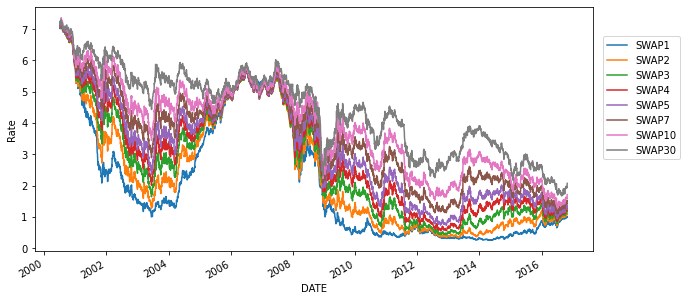

In [39]:
swap_df.plot(figsize=(10,5))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.show()

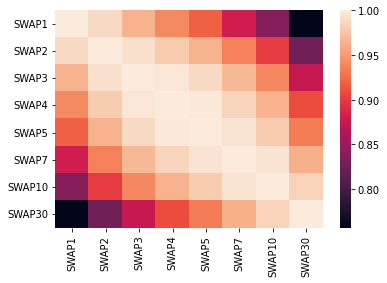

In [40]:
sns.heatmap(swap_df.corr())
plt.show()

### Treasury Rates Data

#### Option #1 We can use quandle

In [82]:
treasury = ['FRED/DGS1MO',
           'FRED/DGS3MO',
           'FRED/DGS6MO',
           'FRED/DGS1',
           'FRED/DGS2',
           'FRED/DGS3',
           'FRED/DGS5',
           'FRED/DGS7',
           'FRED/DGS10',
           'FRED/DGS20',
           'FRED/DGS30']

treasury_df = quandl.get(treasury)
treasury_df.columns = ['TRESY1mo',
                    'TRESY3mo', 
                    'TRESY6mo',
                    'TRESY1y',
                    'TRESY2y',
                    'TRESY3y',
                    'TRESY5y',
                    'TRESY7y',
                    'TRESY10y',
                    'TRESY20y',
                    'TRESY30y']

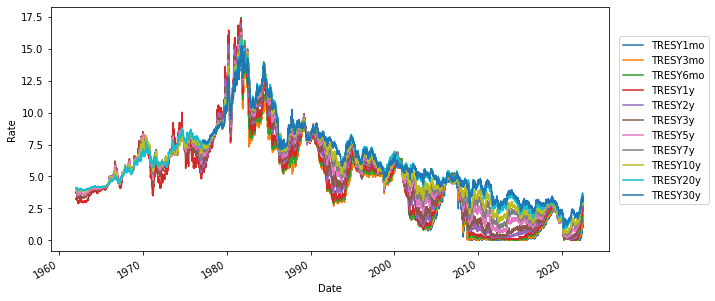

In [83]:
treasury_df.plot(figsize=(10,5))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01,.9), loc=2)
plt.show()

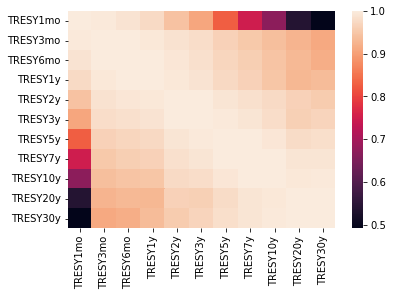

In [84]:
sns.heatmap(treasury_df.corr())
plt.show()

#### Option #2 We can use fredapi

We may use Market Yield on U.S. Treasury Securities at (1,2,5,7,10,20)30-Year Constant Maturity, Quoted on an Investment Basis https://fred.stlouisfed.org/series/DGS30 

In [147]:
startDate = '2000-01-01'
endDate = '2023-01-01'
df = []
ids = ['DGS{}'.format(i) for i in ['1MO', '3MO', '6MO', 1,2,5,7,10,20,30]]
for s in ids:
    df.append(fred.get_series(s, observation_start=startDate, observation_end=endDate)/100)
  
df = pd.concat(df,axis=1)
df.columns = ids
df = df.dropna()

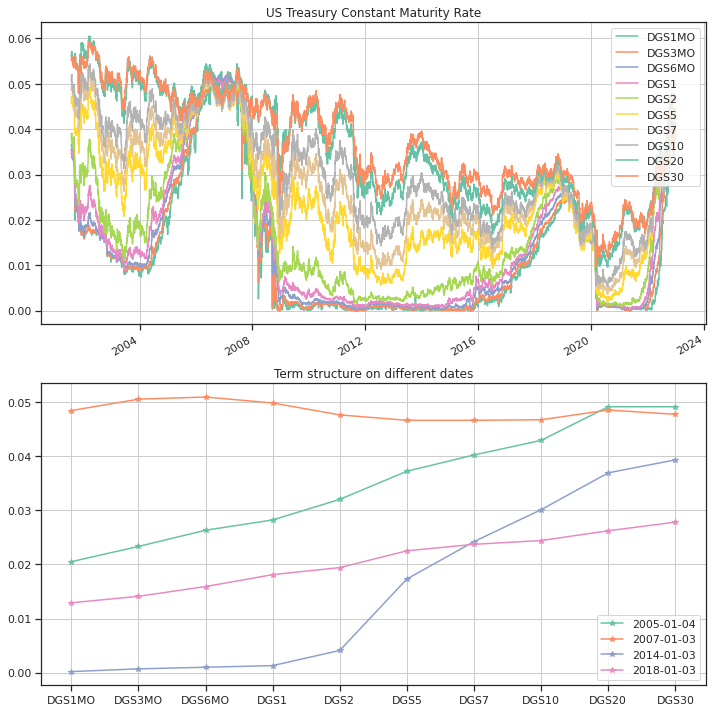

In [148]:
fig,(ax,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(10,5*2))
df.plot(grid=True,title='US Treasury Constant Maturity Rate',ax=ax)
x = df.loc[[datetime(2005,1,4),datetime(2007,1,3),datetime(2014,1,3),datetime(2018,1,3)],:]
x.index = [t.date() for t in x.index]
ax2.plot(x.T.index,x.T,marker='*')
ax2.legend(x.index)
ax2.grid(True)
ax2.set_title('Term structure on different dates')
fig.tight_layout()

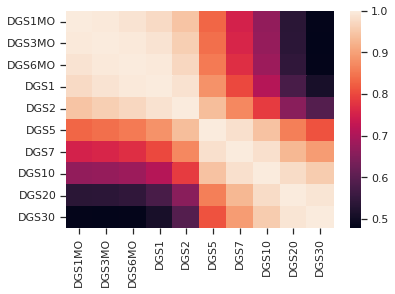

In [149]:
sns.heatmap(df.corr())
plt.show()

### Spread Data is here https://fred.stlouisfed.org/categories/33446?t=&et=&ptic=36&ob=t&od=&tg=&tt=

#### Option #1

In [119]:
spread = [comb_df.SWAP1-comb_df.TRESY1y, 
        comb_df.SWAP2-comb_df.TRESY2y,
       comb_df.SWAP3-comb_df.TRESY3y,
       comb_df.SWAP5-comb_df.TRESY5y,
       comb_df.SWAP7-comb_df.TRESY7y,
       comb_df.SWAP10-comb_df.TRESY10y]
spread_df = pd.DataFrame(np.array(spread).T, index=comb_df.index, 
                         columns = ["SPREAD1y", "SPREAD2y", "SPREAD3y", "SPREAD5y", "SPREAD7y", "SPREAD10y"])

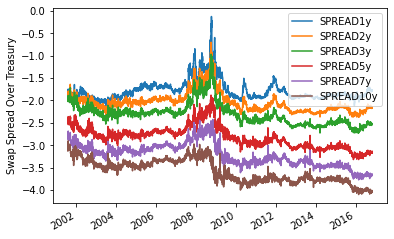

In [120]:
spread_df.plot()
plt.ylabel("Swap Spread Over Treasury")
plt.show()

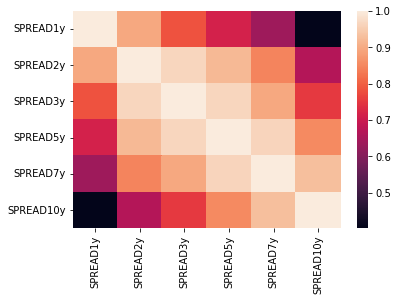

In [121]:
sns.heatmap(spread_df.corr())
plt.show()

#### Option #2

## Defining finctions

In [106]:
def PCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecs

In [138]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA


class PCABase(object):
    def __init__(self, X, adjust_sign=True):
        self.X = X
        self.n_features = X.shape[1]
        self.dates = X.index
        self.Xc = self.X - self.X.mean()  # centered
        self.pc_names = lambda n: ['PC' + str(i) for i in np.arange(1, n + 1)]
        self.adjust_sign = adjust_sign


    def pca(self, n_pc=None):
        '''
        fit pca model
        n_pc: number of pcs to fit, take total feature numbers if not specified
        '''
        if n_pc:
            model = PCA(n_components=n_pc).fit(self.Xc)
        else:
            model = PCA().fit(self.Xc)
        return model

    def cps(self):
        '''
        loading matrix => principal axes in feature space
        '''
        cps = self.pca().components_.T
        cps = self.to_df_pc(cps, is_loading=True)
        if self.adjust_sign:
            cps.loc[:, 'PC1'] = np.sign(cps.loc[:, 'PC1'].values[0]) * cps.loc[:, 'PC1']
            cps.loc[:, 'PC2'] = -np.sign(cps.loc[:, 'PC2'].values[0]) * cps.loc[:, 'PC2']
        return cps

    def cumsum_expvar_ratio(self):
        var_exp = self.pca().explained_variance_ratio_
        var_exp_cumsum = np.cumsum(var_exp)
        return var_exp, var_exp_cumsum

    def scores(self):
        '''
        PC scores:
        '''
        scores = self.pca().transform(self.Xc)
        scores = self.to_df_pc(scores)
        if self.adjust_sign:
            cps = self.cps()
            scores.loc[:, 'PC1'] = np.sign(cps.loc[:, 'PC1'].values[0]) * scores.loc[:, 'PC1']
            scores.loc[:, 'PC2'] = -np.sign(cps.loc[:, 'PC2'].values[0]) * scores.loc[:, 'PC2']
        return scores

    def scores2(self):
        '''
        equivalent to the sklearn transform function
        '''
        scores = self.Xc.dot(self.cps())
        scores = self.to_df_pc(scores)
        if self.adjust_sign:
            cps = self.cps()
            scores.loc[:, 'PC1'] = np.sign(cps.loc[:, 'PC1'].values[0]) * scores.loc[:, 'PC1']
            scores.loc[:, 'PC2'] = -np.sign(cps.loc[:, 'PC2'].values[0]) * scores.loc[:, 'PC2']
        return scores

    def x_projected(self, p, centered=False):
        xp = self.scores().iloc[:, 0:p].dot(self.cps().T.iloc[0:p, :])
        if not centered:
            xp = xp + self.X.mean()
        return xp

    def residuals(self, p):
        residuals = self.X - self.x_projected(p, centered=False)
        return residuals

    def covX(self):
        return self.X.cov()

    def eigenv(self):
        eig_vals, eig_vecs = np.linalg.eig(self.covX())
        return eig_vals, eig_vecs

    def to_df_pc(self, data, is_loading=False):
        cols = self.pc_names(self.n_features)
        idx = self.X.columns if is_loading else self.dates
        return pd.DataFrame(data, columns=cols, index=idx)

## Data Analysis

### Applying PCA to Swap Data

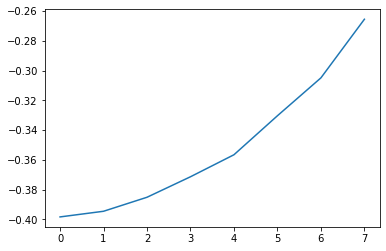

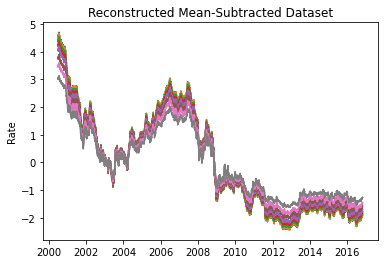

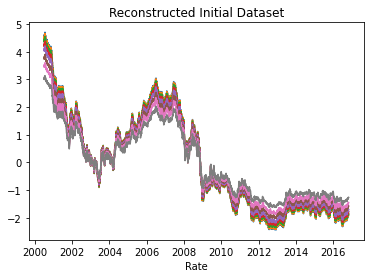

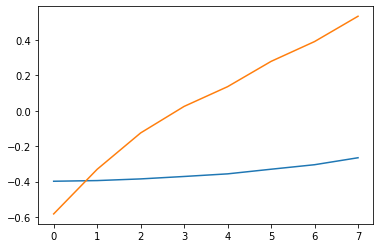

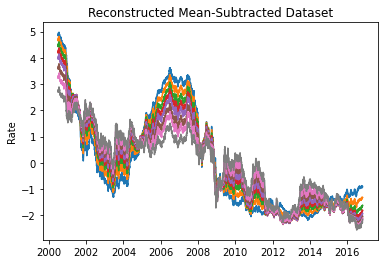

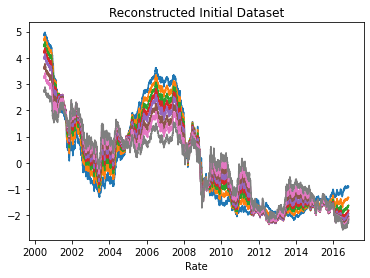

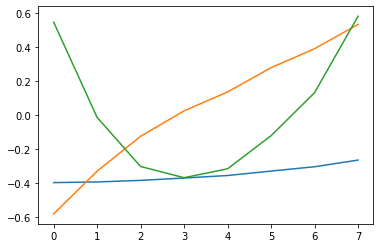

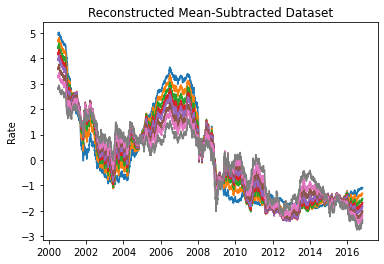

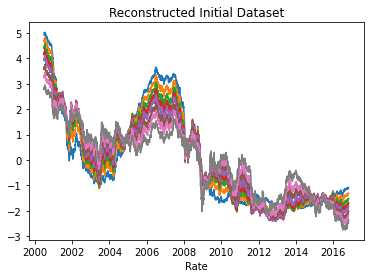

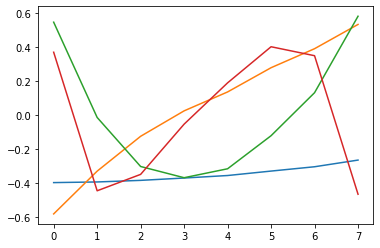

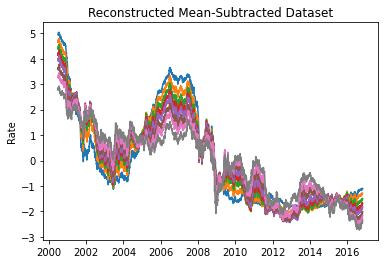

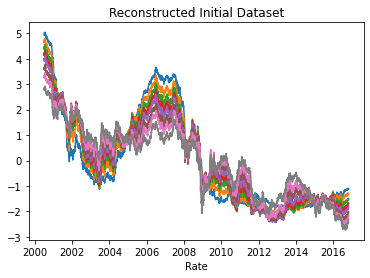

In [107]:
vec = [1,2,3,4]
swap_df2 = swap_df.copy()

for i in vec:
  scores, evals, evecs = PCA(swap_df, i)
  evecs = pd.DataFrame(evecs)
  plt.plot(evecs)
  plt.show()
  reconst = pd.DataFrame(np.dot(scores,evecs.T), index=swap_df.index, columns=swap_df.columns)
  plt.plot(reconst)
  plt.ylabel("Rate")
  plt.title("Reconstructed Mean-Subtracted Dataset")
  plt.show()
  for cols in reconst.columns:
    reconst[cols] = reconst[cols] + swap_df2.mean(axis=0)[cols]
  plt.plot(reconst)
  plt.xlabel("Rate")
  plt.title("Reconstructed Initial Dataset")
  plt.show()


We can see from pictures above that 3 features as suggested by ... in 1991 explain the rate behaviour.

We reconstruct the intial data set with 3 components.

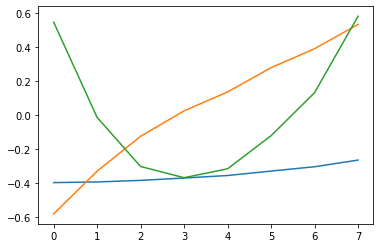

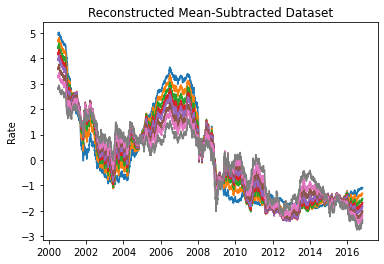

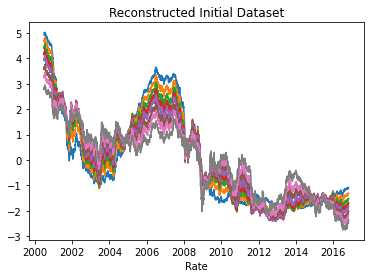

In [108]:
vec = 3
scores, evals, evecs = PCA(swap_df, vec)
evecs = pd.DataFrame(evecs)
plt.plot(evecs)
plt.show()
reconst = pd.DataFrame(np.dot(scores,evecs.T), index=swap_df.index, columns=swap_df.columns)
plt.plot(reconst)
plt.ylabel("Rate")
plt.title("Reconstructed Mean-Subtracted Dataset")
plt.show()
for cols in reconst.columns:
  reconst[cols] = reconst[cols] + swap_df2.mean(axis=0)[cols]
plt.plot(reconst)
plt.xlabel("Rate")
plt.title("Reconstructed Initial Dataset")
def PCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecsplt.show()

In [109]:
def scores(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T
scores = scores(swap_df, 4)
scores

array([[-1.15767690e+01, -5.44120969e-01,  1.38819687e-01,
         7.15843794e-03],
       [-1.13202667e+01, -5.79376590e-01,  1.48919811e-01,
         1.53019503e-02],
       [-1.15100297e+01, -5.45352438e-01,  1.22278983e-01,
         1.86025718e-02],
       ...,
       [ 4.82226163e+00, -1.77852980e+00, -3.57087046e-01,
        -4.66978863e-02],
       [ 4.71686790e+00, -1.67853872e+00, -3.45062561e-01,
        -4.78969804e-02],
       [ 4.73880957e+00, -1.67973761e+00, -3.30639389e-01,
        -4.72176390e-02]])

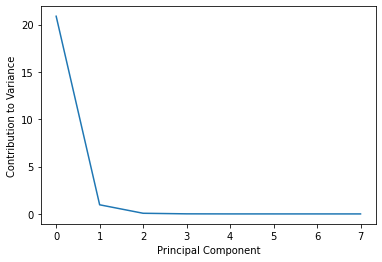

In [110]:
plt.plot(evals)
plt.ylabel("Contribution to Variance")
plt.xlabel("Principal Component")
plt.show()

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [111]:
from sklearn.decomposition import PCA as PCA_2

In [112]:

n_components = [1,2,3,4,5,6,7]
for i in n_components:
  pca = PCA(i)
  pca.fit(swap_df)
  print("number of components is ",i)
  print("variance explained: ", pca.explained_variance_ratio_)
  print("singular values: ", pca.singular_values_)
  print(" ------------------------------------------------------------ ")

TypeError: ignored

In [92]:
PCA_2(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

PCA(n_components=3)

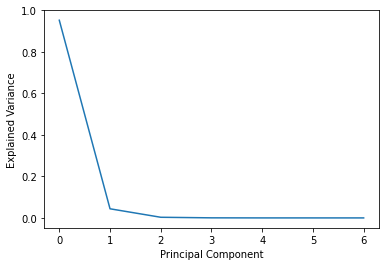

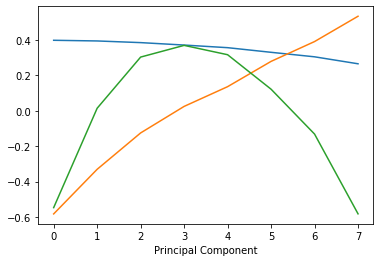

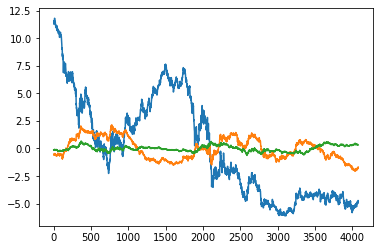

In [93]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.show()

plt.plot(pca.components_[0:3].T)
plt.xlabel("Principal Component")
plt.show()

vals = pca.transform(swap_df)
plt.plot(vals[:,0:3])
plt.show()

### Applying PCA to Treasury Data

#### Option 1

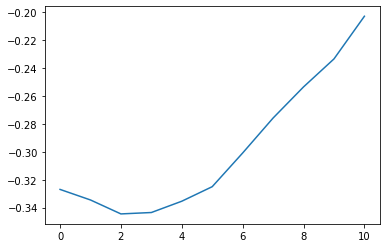

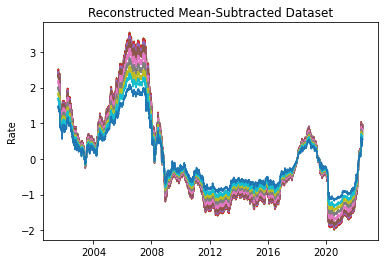

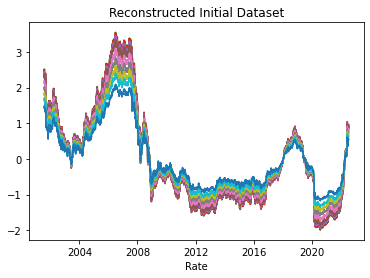

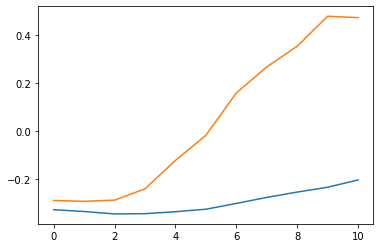

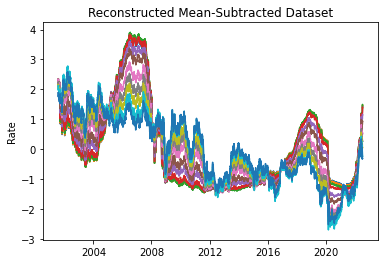

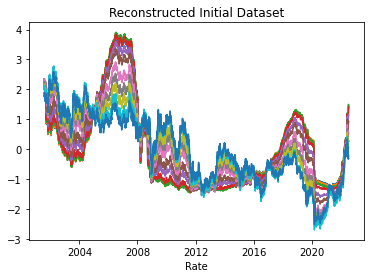

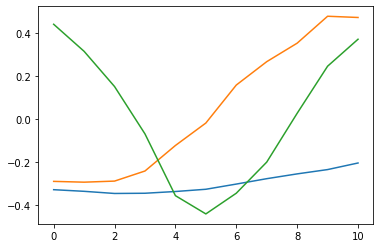

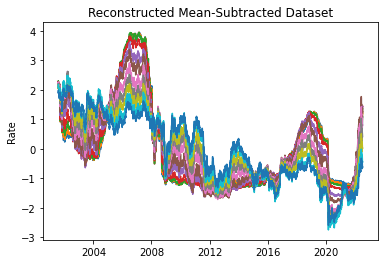

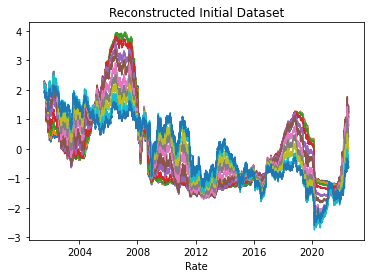

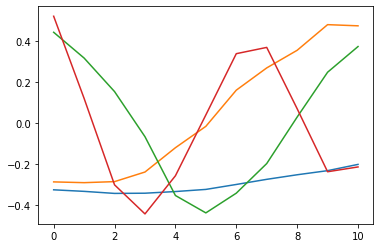

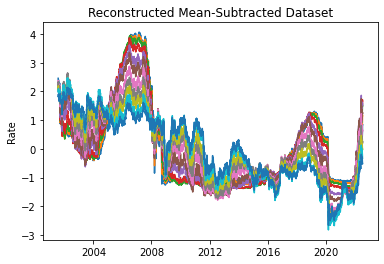

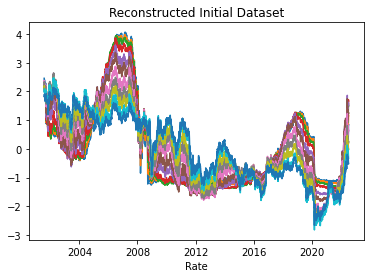

In [95]:
vec = [1,2,3,4]
#treasury_df2 = treasury_df.ix[:, 3:-2]
treasury_df2 = treasury_df.dropna()
comb_df = treasury_df2.merge(swap_df2, left_index=True, right_index=True)

for i in vec:
  scores, evals, evecs = PCA(treasury_df2, i)
  evecs = pd.DataFrame(evecs)
  plt.plot(evecs)
  plt.show()
  reconst = pd.DataFrame(np.dot(scores,evecs.T), index=treasury_df2.index, columns=treasury_df2.columns)
  plt.plot(reconst)
  plt.ylabel("Rate")
  plt.title("Reconstructed Mean-Subtracted Dataset")
  plt.show()
  for cols in reconst.columns:
    reconst[cols] = reconst[cols] + treasury_df2.mean(axis=0)[cols]
  plt.plot(reconst)
  plt.xlabel("Rate")
  plt.title("Reconstructed Initial Dataset")
  plt.show()

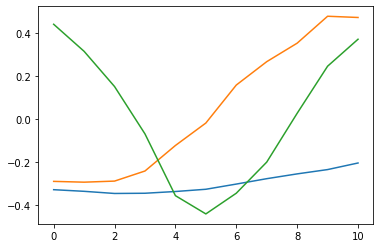

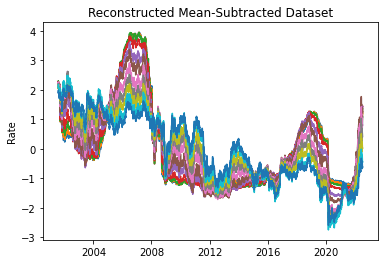

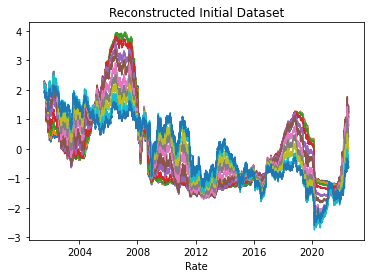

In [97]:
vec = 3
scores, evals, evecs = PCA(treasury_df2, vec)
evecs = pd.DataFrame(evecs)
plt.plot(evecs)
plt.show()
reconst = pd.DataFrame(np.dot(scores,evecs.T), index=treasury_df2.index, columns=treasury_df2.columns)
plt.plot(reconst)
plt.ylabel("Rate")
plt.title("Reconstructed Mean-Subtracted Dataset")
plt.show()
for cols in reconst.columns:
  reconst[cols] = reconst[cols] + treasury_df2.mean(axis=0)[cols]
plt.plot(reconst)
plt.xlabel("Rate")
plt.title("Reconstructed Initial Dataset")
def PCA(df, num_reconstruct):
    
    df -= df.mean(axis=0)
    R = np.cov(df, rowvar=False)
    eigenvals, eigenvecs = sp.linalg.eigh(R)
    eigenvecs = eigenvecs[:, np.argsort(eigenvals)[::-1]]
    eigenvals = eigenvals[np.argsort(eigenvals)[::-1]]
    eigenvecs = eigenvecs[:, :num_reconstruct]

    return np.dot(eigenvecs.T, df.T).T, eigenvals, eigenvecsplt.show()

In [ ]:
n_components = [1,2,3,4,5,6,7]

for t in n_components:
  pca = PCA(t)
  pca.fit(treasury_df2)
  print("number of components is ",i)
  print("variance explained: ", pca.explained_variance_ratio_)
  print("singular values: ", pca.singular_values_)
  print(" ------------------------------------------------------------ ")

In [98]:
omb_df = treasury_df2.merge(swap_df2, left_index=True, right_index=True)

In [100]:
pca_t = PCA_2(n_components=6)
pca_t.fit(treasury_df2)

PCA(n_components=6)

In [101]:
PCA_2(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

PCA(n_components=6)

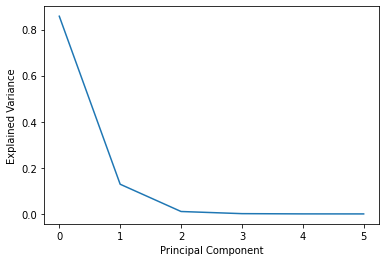

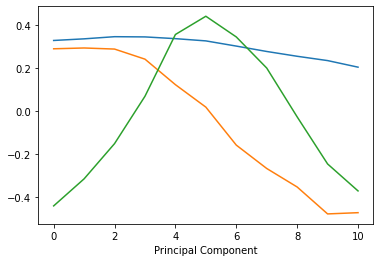

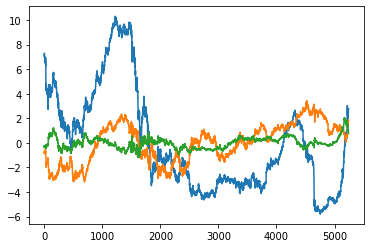

In [118]:
plt.plot(pca_t.explained_variance_ratio_)
plt.ylabel("Explained Variance")
plt.xlabel("Principal Component")
plt.show()

plt.plot(pca_t.components_[0:3].T)
plt.xlabel("Principal Component")
plt.show()

vals_t = pca_t.transform(treasury_df2)
plt.plot(vals_t[:,0:3])
plt.show()

#### Option #2

In [150]:
pcab = PCABase(df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
DGS1MO,0.348263,-0.276252,-0.462781,-0.527567,-0.245677,0.285357,0.320182,0.241433,0.033638,0.078620
DGS3MO,0.358793,-0.286351,-0.295390,-0.090388,0.132740,-0.131109,-0.488484,-0.555608,-0.196110,-0.270665
DGS6MO,0.370574,-0.285464,-0.091990,0.318492,0.376007,-0.249524,-0.047514,0.189006,0.490260,0.435094
DGS1,0.368897,-0.240142,0.153742,0.427969,0.031749,-0.036064,0.231125,0.387814,-0.487415,-0.394654
DGS2,0.357064,-0.120232,0.458061,0.196579,-0.539500,0.257643,0.082092,-0.407112,0.091049,0.267163
DGS5,0.314622,0.162904,0.431002,-0.357320,-0.014589,-0.036525,-0.286383,0.274821,0.436769,-0.459542
DGS7,0.286417,0.271522,0.266321,-0.365133,0.187745,-0.172807,-0.160163,0.123595,-0.521023,0.512337
DGS10,0.261235,0.358744,0.011079,-0.087858,0.330211,-0.183320,0.660645,-0.418276,0.103940,-0.174244
DGS20,0.239413,0.480436,-0.227619,0.274527,0.230731,0.697569,-0.206045,0.047092,0.009071,0.009699
DGS30,0.206134,0.477804,-0.384755,0.214897,-0.539292,-0.469078,-0.099388,0.114765,0.032771,-0.001327


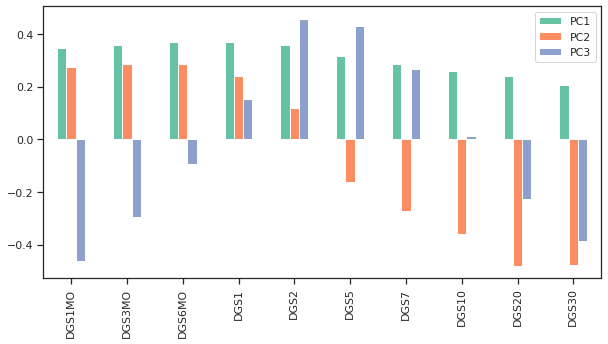

In [151]:
# loading matrix (direction may change but doesn't matter)
V = pd.DataFrame(pcab.pca().components_,index=pcab.pc_names(pcab.n_features),columns=pcab.X.columns)
V.T.iloc[:,0:3].plot(figsize=(10,5),kind='bar')
pcab.cps()

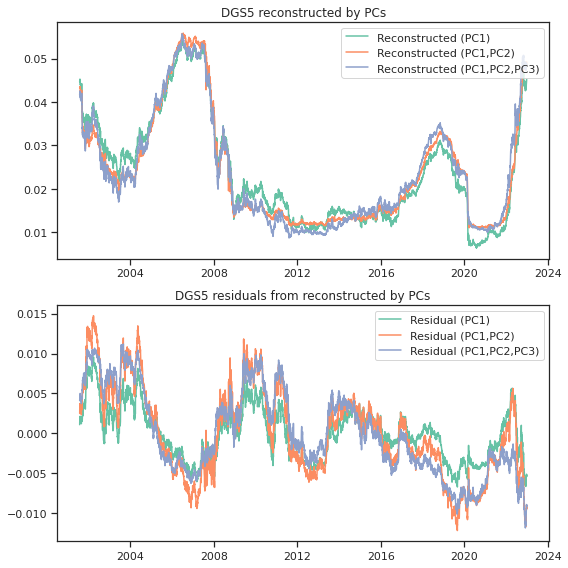

In [152]:
r = 'DGS5'
fig,(ax,ax2)=plt.subplots(figsize=(8,4*2),ncols=1,nrows=2)
ax.plot(pcab.x_projected(1)[r])
ax.plot(pcab.x_projected(2)[r])
ax.plot(pcab.x_projected(3)[r])
ax.legend(['Reconstructed (PC1)','Reconstructed (PC1,PC2)','Reconstructed (PC1,PC2,PC3)'])
ax.set_title('{} reconstructed by PCs'.format(r))

ax2.plot(pcab.residuals(1)[r])
ax2.plot(pcab.residuals(2)[r])
ax2.plot(pcab.residuals(3)[r])
ax2.legend(['Residual (PC1)','Residual (PC1,PC2)','Residual (PC1,PC2,PC3)'])
ax2.set_title('{} residuals from reconstructed by PCs'.format(r))
fig.tight_layout()

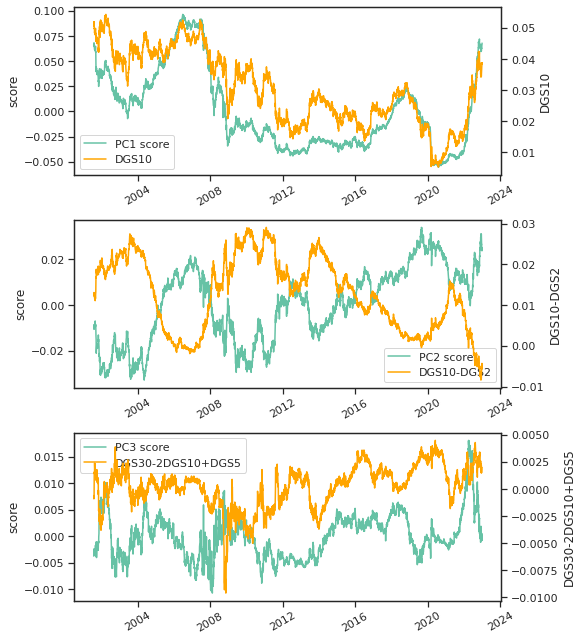

In [153]:
# PC Scores
fig,(ax1,ax2,ax3)=plt.subplots(nrows=3,ncols=1,figsize=(8,3*3))
l1=ax1.plot(pcab.scores()['PC1'])
ax12 = ax1.twinx()
l2=ax12.plot(pcab.X['DGS10'],color='orange')
ax1.tick_params('x',rotation=30)
ax1.legend(l1+l2,['PC1 score','DGS10'])
ax1.set_ylabel('score')
ax12.set_ylabel('DGS10')
# 
l1=ax2.plot(pcab.scores()['PC2'])
ax22 = ax2.twinx()
l2=ax22.plot(pcab.X['DGS10']-pcab.X['DGS2'],color='orange')
ax2.tick_params('x',rotation=30)
ax2.legend(l1+l2,['PC2 score','DGS10-DGS2'],loc='best')
ax2.set_ylabel('score')
ax22.set_ylabel('DGS10-DGS2')

# 
l1=ax3.plot(pcab.scores()['PC3'])
ax32 = ax3.twinx()
l2=ax32.plot(pcab.X['DGS30']-2*pcab.X['DGS10']+pcab.X['DGS5'],color='orange')
ax3.tick_params('x',rotation=30)
ax3.legend(l1+l2,['PC3 score','DGS30-2DGS10+DGS5'],loc='best')
ax3.set_ylabel('score')
ax32.set_ylabel('DGS30-2DGS10+DGS5')
fig.tight_layout()

Text(0.5, 1.0, 'Evolution of PCA Factors 1,2,3')

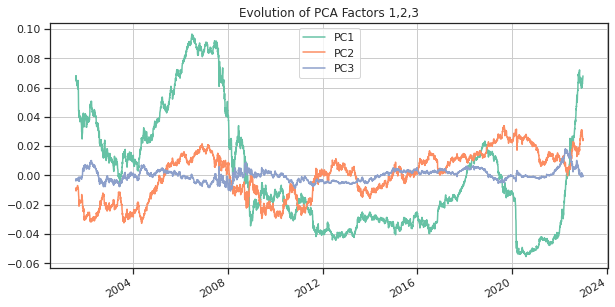

In [154]:
# PC
fig,ax=plt.subplots(figsize=(10,5))
l1=pcab.scores().iloc[:,0:3].plot(ax=ax)
ax.grid(True)
ax.set_title('Evolution of PCA Factors 1,2,3')

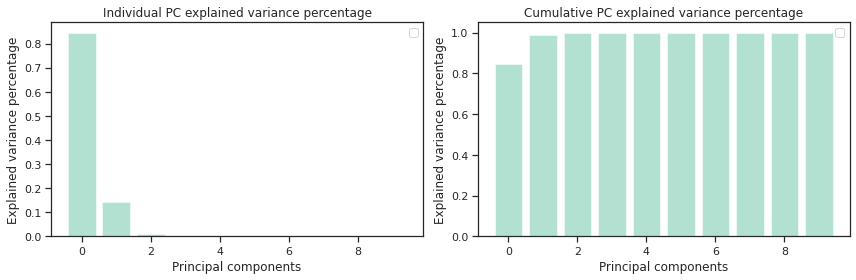

In [155]:
fig,(ax,ax2) = plt.subplots(figsize=(6*2, 4),ncols=2,nrows=1)
ax.bar(range(pcab.n_features), pcab.cumsum_expvar_ratio()[0], alpha=0.5, align='center')
ax2.bar(range(pcab.n_features), pcab.cumsum_expvar_ratio()[1], alpha=0.5, align='center')
ax.set_ylabel('Explained variance percentage')
ax.set_xlabel('Principal components')
ax.set_title('Individual PC explained variance percentage')
ax.legend(loc='best')
ax2.set_ylabel('Explained variance percentage')
ax2.set_xlabel('Principal components')
ax2.set_title('Cumulative PC explained variance percentage')
ax2.legend(loc='best')
fig.tight_layout()

### Applying Clustering to Treasury Data

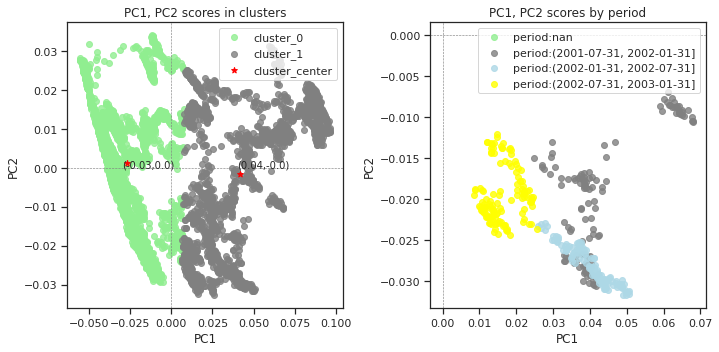

In [156]:
from sklearn.cluster import KMeans
def model_kmeans(data,n_clusters=3,init_method = 'k-means++',n_init=10):
  model = KMeans(n_clusters=n_clusters,
                  init=init_method,
                  n_init=n_init)
  model.fit(data)
  cluster_labels = model.predict(data)
  cluster_centers = model.cluster_centers_
  fit_res = {'cluster_method':'kmeans',
              'model':model,
              'cluster_labels':cluster_labels,
              'cluster_centers':cluster_centers,
              'data':data}
  return fit_res

s2 = pcab.scores()[['PC1','PC2']]
kmeans = model_kmeans(s2,n_clusters=2)  
X = s2.reset_index()
X = X.rename(columns={'index':'date'})

feature_pair = ['PC1','PC2']
fig,(ax,ax2)=plt.subplots(ncols=2,nrows=1,figsize=(10,5))
cluster_labels = kmeans['cluster_labels']
X['cluster_label'] = cluster_labels
cluster_centers = kmeans['cluster_centers']
mode_fitted = kmeans['model']
label_order = sorted(list(set(cluster_labels)))
colors = ['lightgreen','grey','lightblue','yellow']
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, [1,2,5,10])]
color_map_clusters = dict(zip(label_order, colors))
for (c_label,color) in color_map_clusters.items():
  x = X[X['cluster_label']==c_label][feature_pair[0]]
  y = X[X['cluster_label']==c_label][feature_pair[1]]
  ax.scatter(x,y,c=color,alpha=0.8)
ax.legend()
ax.scatter(cluster_centers[:,0],cluster_centers[:,1],c='red',marker='*')
# add cluster center annotion
for xy in tuple(np.round(cluster_centers,2)):
  ax.annotate("({},{})".format(xy[0],xy[1]),xy=(xy[0],xy[1]))
ax.set_xlabel(feature_pair[0])
ax.set_ylabel(feature_pair[1])
ax.legend(['cluster_{}'.format(c) for c in set(cluster_labels)]+['cluster_center'])
ax.set_title('PC1, PC2 scores in clusters')
ax.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax.axvline(x=0,ls='--',color='grey',linewidth=0.6)
# 
X['date'] = pd.to_datetime(X['date'])
periods = pd.date_range(X['date'].iloc[0]-pd.Timedelta(days=3),X['date'].iloc[-1],freq='6M')
X['date_bucket'] = pd.cut(X['date'],bins=periods)
color_map_periods = dict(zip(X['date_bucket'].unique(), colors))
for (p_label,color) in color_map_periods.items():
  x = X[X['date_bucket']==p_label][feature_pair[0]]
  y = X[X['date_bucket']==p_label][feature_pair[1]]
  ax2.scatter(x,y,c=color,alpha=0.8)
ax2.legend()

ax2.set_xlabel(feature_pair[0])
ax2.set_ylabel(feature_pair[1])
ax2.set_title('PC1, PC2 scores by period')
ax2.legend(['period:{}'.format(c) for c in X['date_bucket'].unique()])
ax2.axhline(y=0,ls='--',color='grey',linewidth=0.6)
ax2.axvline(x=0,ls='--',color='grey',linewidth=0.6)
fig.tight_layout()

### Applying PCA to Spreads

In [122]:
pca_spread = PCA_2(n_components=6)
pca_spread.fit(spread_df)

PCA(n_components=6)

In [123]:
PCA_2(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

PCA(n_components=6)

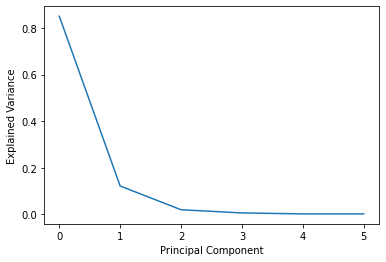

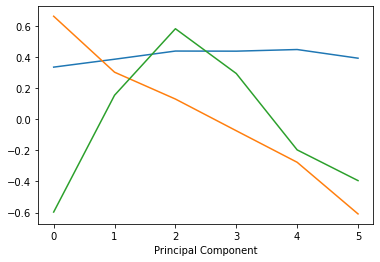

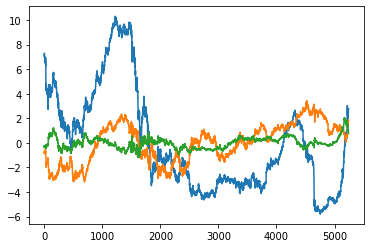

In [124]:
plt.plot(pca_spread.explained_variance_ratio_)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.show()

plt.plot(pca_spread.components_[0:3].T)
plt.xlabel("Principal Component")
plt.show()

vals_s = pca_spread.transform(spread_df)
plt.plot(vals_t[:,0:3])
plt.show()